In [473]:
!pip3 install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import multilabel_confusion_matrix
import keras_tuner as kt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:

# List all available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Specifically check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available: {gpus}")
else:
    print("GPU is not available.")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
#
def load_mnist():
    # Load the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    return train_images, train_labels, test_images, test_labels

def preprocessing_data(images):
    images = images.reshape((images.shape[0], 28, 28, 1))
    images = images / 255.0
    return images

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.001),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00003, momentum=0.356),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

#How to set up a CV loop for a computer vision problem?

def cv_loop(n_splits, train_images, train_labels):
    cv_metrics_range = {}
    entire_history = {}
    np.random.seed(1234)
    tf.random.set_seed(1234)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold_no, (train, val) in enumerate(kf.split(train_images, train_labels)):
        tf.keras.backend.clear_session()
        model = model_build()
        
        # Save the model if you need to use it later
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model_fold_{fold_no}.h5', monitor='val_loss',mode='min', save_best_only=True)
    
        history = model.fit(
            train_images[train], train_labels[train],
            batch_size=256,
            epochs=10,
            verbose=1,
            validation_data=(train_images[val], train_labels[val]), callbacks=[callbacks, model_checkpoint]
        )
        
        entire_history[f"fold_{fold_no+1}"] = history.history
        
    for k in entire_history.keys():
        cv_metrics_range['avg_training_accuracy'] = np.mean(entire_history[k]['accuracy'])
        cv_metrics_range['avg_val_accuracy'] = np.mean(entire_history[k]['val_accuracy'])
        cv_metrics_range['avg_training_loss'] = np.mean(entire_history[k]['loss'])
        cv_metrics_range['avg_val_loss'] = np.mean(entire_history[k]['val_loss'])
        
    return entire_history, cv_metrics_range
        

## FYI

# Get number of weights
# model_params = model.count_params()


In [343]:
# model = model_build()

train_images, train_labels, test_images, test_labels = load_mnist()

train_images = preprocessing_data(train_images)
# test_images = preprocessing_data(test_images)
# 
# # Get number of weights
# model_params = model.count_params()

# # Instantiate the callback class
callbacks = myCallback()

history = cv_loop(3, train_images, train_labels)


Epoch 1/10
157/157 [==============================] - 3s 19ms/step - loss: 2.2573 - accuracy: 0.1673 - val_loss: 2.2078 - val_accuracy: 0.2464
Epoch 2/10
157/157 [==============================] - 2s 15ms/step - loss: 2.1312 - accuracy: 0.3167 - val_loss: 2.0281 - val_accuracy: 0.3979
Epoch 3/10
157/157 [==============================] - 3s 17ms/step - loss: 1.8921 - accuracy: 0.4747 - val_loss: 1.7204 - val_accuracy: 0.5488
Epoch 4/10
157/157 [==============================] - 2s 13ms/step - loss: 1.5337 - accuracy: 0.5998 - val_loss: 1.3241 - val_accuracy: 0.6528
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 1.1340 - accuracy: 0.7074 - val_loss: 0.9542 - val_accuracy: 0.7564
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.8292 - accuracy: 0.7834 - val_loss: 0.7196 - val_accuracy: 0.8062
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.6542 - accuracy: 0.8131 - val_loss: 0.5949 - val_accuracy: 0.8272

In [344]:
history


{'fold_1': {'loss': [2.2572665214538574,
   2.1312153339385986,
   1.892107605934143,
   1.5336917638778687,
   1.1340025663375854,
   0.8292331099510193,
   0.6542360186576843,
   0.5594937801361084,
   0.5025875568389893,
   0.46244296431541443],
  'accuracy': [0.16727499663829803,
   0.3167249858379364,
   0.47472500801086426,
   0.5998499989509583,
   0.7074000239372253,
   0.783424973487854,
   0.8131499886512756,
   0.8322749733924866,
   0.8488249778747559,
   0.8591499924659729],
  'val_loss': [2.207799196243286,
   2.0280845165252686,
   1.72036874294281,
   1.3241405487060547,
   0.9541622996330261,
   0.7196111083030701,
   0.5948843955993652,
   0.522157609462738,
   0.4732341766357422,
   0.4401648938655853],
  'val_accuracy': [0.24639999866485596,
   0.3979499936103821,
   0.548799991607666,
   0.6528000235557556,
   0.7564499974250793,
   0.8062000274658203,
   0.8271999955177307,
   0.8443499803543091,
   0.8561000227928162,
   0.866599977016449]},
 'fold_2': {'loss': [

In [42]:
def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='validation_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


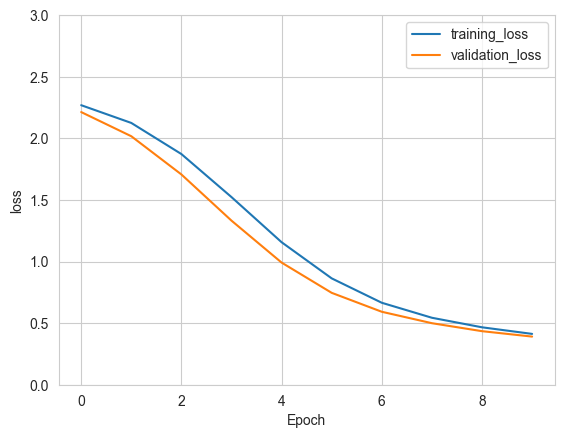

In [355]:
plot_learning_curve_loss(history['fold_3'], 0, 3)

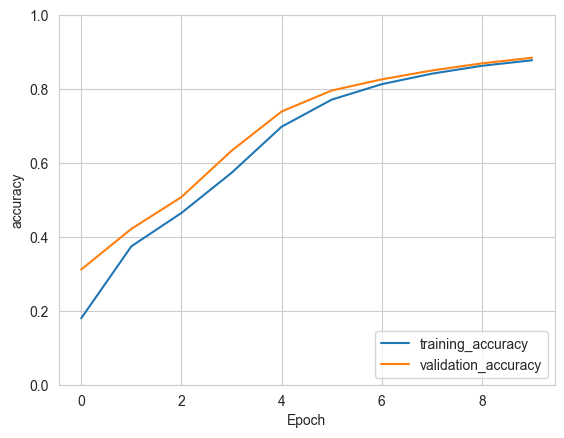

In [354]:
plot_learning_curve_metric(history['fold_3'], 0, 1)

In [6]:
train_images, train_labels, test_images, test_labels = load_mnist()

train_images = preprocessing_data(train_images)
test_images = preprocessing_data(test_images)


In [7]:
import os
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/intro_TF_week3'

In [107]:
test_images.shape

(10000, 28, 28, 1)

In [108]:
test_labels.shape

(10000,)

In [410]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def model_prediction(model_path):
    model = tf.keras.models.load_model(model_path)
    
    predicted_labels = model.predict(test_images)
    
    predicted_labels = np.argmax(predicted_labels, axis=1)
    
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(test_labels, predicted_labels)
    accuracy_result = accuracy.result().numpy()
    
    conf_matrix = multilabel_confusion_matrix(test_labels, predicted_labels)
    
    return accuracy_result, conf_matrix
    

In [411]:
#Accuracy and Confusion matrix using model_fold_0.h5

acc_model0, conf_model0 = model_prediction('/Users/chidam_sp/PycharmProjects/pythonProject2/intro_TF_week3/model_fold_0.h5')


313/313 [==============================] - 1s 2ms/step


In [412]:
#Accuracy and Confusion matrix using model_fold_1.h5

acc_model1, conf_model1 = model_prediction('/Users/chidam_sp/PycharmProjects/pythonProject2/intro_TF_week3/model_fold_1.h5')


313/313 [==============================] - 1s 2ms/step


In [417]:
acc_model1

0.897

In [414]:
acc_model1

0.897

In [415]:
conf_model1

array([[[8951,   69],
        [  36,  944]],

       [[8822,   43],
        [  44, 1091]],

       [[8881,   87],
        [ 135,  897]],

       [[8883,  107],
        [ 141,  869]],

       [[8944,   74],
        [ 118,  864]],

       [[8964,  144],
        [ 106,  786]],

       [[8927,  115],
        [  80,  878]],

       [[8900,   72],
        [ 127,  901]],

       [[8855,  171],
        [ 133,  841]],

       [[8843,  148],
        [ 110,  899]]])

In [413]:
#Accuracy and Confusion matrix using model_fold_1.h5

acc_model2, conf_model2 = model_prediction('/Users/chidam_sp/PycharmProjects/pythonProject2/intro_TF_week3/model_fold_2.h5')


313/313 [==============================] - 1s 2ms/step


In [416]:
acc_model2

0.8893

In [418]:
conf_model2

array([[[8940,   80],
        [  30,  950]],

       [[8812,   53],
        [  38, 1097]],

       [[8860,  108],
        [ 120,  912]],

       [[8847,  143],
        [  84,  926]],

       [[8905,  113],
        [ 138,  844]],

       [[9012,   96],
        [ 153,  739]],

       [[8953,   89],
        [  93,  865]],

       [[8884,   88],
        [ 151,  877]],

       [[8912,  114],
        [ 151,  823]],

       [[8768,  223],
        [ 149,  860]]])

In [10]:
train_images.shape

(60000, 28, 28, 1)

In [11]:
train_labels.shape

(60000,)

In [63]:
import numpy as np
# min_value=0.19, max_value=0.3, step=0.001
for i in np.arange(0.19, 0.4, 0.001):
    print(i)

0.19
0.191
0.192
0.193
0.194
0.195
0.196
0.197
0.198
0.199
0.2
0.201
0.202
0.203
0.20400000000000001
0.20500000000000002
0.20600000000000002
0.20700000000000002
0.20800000000000002
0.20900000000000002
0.21000000000000002
0.21100000000000002
0.21200000000000002
0.21300000000000002
0.21400000000000002
0.21500000000000002
0.21600000000000003
0.21700000000000003
0.21800000000000003
0.21900000000000003
0.22000000000000003
0.22100000000000003
0.22200000000000003
0.22300000000000003
0.22400000000000003
0.22500000000000003
0.22600000000000003
0.22700000000000004
0.22800000000000004
0.22900000000000004
0.23000000000000004
0.23100000000000004
0.23200000000000004
0.23300000000000004
0.23400000000000004
0.23500000000000004
0.23600000000000004
0.23700000000000004
0.23800000000000004
0.23900000000000005
0.24000000000000005
0.24100000000000005
0.24200000000000005
0.24300000000000005
0.24400000000000005
0.24500000000000005
0.24600000000000005
0.24700000000000005
0.24800000000000005
0.24900000000000005

In [85]:

def model_builder(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(hp.Int('first_unit', min_value=32, max_value=420, step=32), (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(hp.Int('second_unit', min_value=8, max_value=224, step=8), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(hp.Float('Dropout_rate', min_value=0.19, max_value=0.4, step=0.001)),
        tf.keras.layers.Dense(hp.Int('third_unit', min_value=32, max_value=150, step=32), 
                              activation='relu'),
        tf.keras.layers.Dense(hp.Int('fourth_unit', min_value=8, max_value=100, step=16), activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00003, momentum=0.356), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
# learning_rate=hp.Float('Learning_rate', min_value=0.00003, max_value=0.02, step=0.001


In [640]:

# class CustomTuner(kt.BayesianOptimization):
#   def run_trial(self, trial, *args, **kwargs):
#     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 520, step=32)
#     return super(CustomTuner, self).run_trial(trial, *args, **kwargs)
#   
# hp.Choice("batch_size", [64, 128, 256, 264, 280, 320, 420, 512])

In [ ]:

# Previous
# tuner = kt.BayesianOptimization(model_builder, objective='val_accuracy', max_trials=5, directory='TF_week3_tuning_logs_apr3', project_name='mnist_with_convolutions', overwrite=True)  



In [81]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=2078)

In [80]:
del train_images_split, val_images_split, train_labels_split, val_labels_split

In [82]:
train_images_split.shape

(48000, 28, 28, 1)

In [83]:
val_images_split.shape

(12000, 28, 28, 1)

In [86]:
del stop_early, tuner

In [87]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner = CustomTuner(model_builder, objective='val_loss', max_trials=5, directory='TF_week3_tuning_logs', project_name='mnist_with_convolutions', overwrite=True)

tuner = kt.BayesianOptimization(model_builder, objective='val_loss', max_trials=5, directory='TF_week3_tuning_logs_apr3', project_name='mnist_with_convolutions_apr3', overwrite=True)  

tuner.search(train_images_split, train_labels_split, batch_size=256, validation_data=(val_images_split, val_labels_split), epochs=10, callbacks=[stop_early], verbose=1)


Trial 5 Complete [00h 01m 00s]
val_loss: 0.13688090443611145

Best val_loss So Far: 0.1347844898700714
Total elapsed time: 00h 05m 15s


In [563]:
Previous (very first) result
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
tuner.search(train_images_split, train_labels_split, validation_data=(val_images_split, val_labels_split), epochs=10, callbacks=[stop_early], verbose=1)


Trial 5 Complete [00h 03m 26s]
val_accuracy: 0.9729999899864197

Best val_accuracy So Far: 0.9739166498184204
Total elapsed time: 00h 10m 06s


## Lesson learned
After hyperparameter tuning process, do not keep training the model with the best hyperparameters in order to get different results because the model very soon overfits to the data and starts producing weird results.

In [91]:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [567]:
Previous (very first) result
for hp in best_hps.space:
  print(f"{hp.name}: {best_hps.get(hp.name)}")

input_unit: 96
second_unit: 72
Dropout_rate: 0.0201
third_unit: 192
fourth_unit: 72
learning_rate: 0.0001


In [644]:
Second result
for hp in best_hps.space:
  print(f"{hp.name}: {best_hps.get(hp.name)}")

first_unit: 288
second_unit: 104
Dropout_rate: 0.216
third_unit: 160
dense_activation: sigmoid
fourth_unit: 48
Learning_rate: 0.018000000000000002
Momentum: 0.5
batch_size: 32


In [92]:
# April 3rd result
for hp in best_hps.space:
  print(f"{hp.name}: {best_hps.get(hp.name)}")

first_unit: 32
second_unit: 96
Dropout_rate: 0.247
third_unit: 128
fourth_unit: 40


In [94]:
hypermodel = tuner.hypermodel.build(best_hps)

In [95]:
hypermodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 96)        27744     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 96)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2400)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2400)             

In [568]:
First result
hypermodel = tuner.hypermodel.build(best_hps)



Epoch 1/30
188/188 [==============================] - 6s 25ms/step - loss: 0.9206 - accuracy: 0.7496 - val_loss: 0.3430 - val_accuracy: 0.9025
Epoch 2/30
188/188 [==============================] - 3s 18ms/step - loss: 0.2807 - accuracy: 0.9161 - val_loss: 0.2643 - val_accuracy: 0.9222
Epoch 3/30
188/188 [==============================] - 3s 18ms/step - loss: 0.1967 - accuracy: 0.9398 - val_loss: 0.1752 - val_accuracy: 0.9482
Epoch 4/30
188/188 [==============================] - 4s 20ms/step - loss: 0.1538 - accuracy: 0.9535 - val_loss: 0.1665 - val_accuracy: 0.9524
Epoch 5/30
188/188 [==============================] - 4s 23ms/step - loss: 0.1332 - accuracy: 0.9600 - val_loss: 0.1257 - val_accuracy: 0.9647
Epoch 6/30
188/188 [==============================] - 3s 18ms/step - loss: 0.1161 - accuracy: 0.9650 - val_loss: 0.1015 - val_accuracy: 0.9713
Epoch 7/30
188/188 [==============================] - 3s 17ms/step - loss: 0.1074 - accuracy: 0.9680 - val_loss: 0.0966 - val_accuracy: 0.9724

In [110]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
history_epochs = hypermodel.fit(train_images_split, train_labels_split, epochs=50, batch_size=256, validation_data=(val_images_split, val_labels_split))



Epoch 1/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1196 - accuracy: 0.9651 - val_loss: 0.1102 - val_accuracy: 0.9672
Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1204 - accuracy: 0.9641 - val_loss: 0.0948 - val_accuracy: 0.9715
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 0.1165 - accuracy: 0.9660 - val_loss: 0.0978 - val_accuracy: 0.9707
Epoch 4/50
188/188 [==============================] - 2s 13ms/step - loss: 0.1172 - accuracy: 0.9667 - val_loss: 0.1039 - val_accuracy: 0.9682
Epoch 5/50
188/188 [==============================] - 2s 13ms/step - loss: 0.1184 - accuracy: 0.9670 - val_loss: 0.0931 - val_accuracy: 0.9708
Epoch 6/50
188/188 [==============================] - 2s 13ms/step - loss: 0.1171 - accuracy: 0.9670 - val_loss: 0.0986 - val_accuracy: 0.9712
Epoch 7/50
188/188 [==============================] - 2s 13ms/step - loss: 0.1161 - accuracy: 0.9677 - val_loss: 0.0953 - val_accuracy: 0.9718

In [ ]:
#Second result
first_unit: 288
second_unit: 104
Dropout_rate: 0.216
third_unit: 160
dense_activation: sigmoid
fourth_unit: 48
Learning_rate: 0.018000000000000002
Momentum: 0.5
batch_size: 32

In [36]:
hypermodel = tuner.hypermodel.build(best_hps)

In [37]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 48)        27696     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1200)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1200)             

In [97]:

# first_unit: 64
# second_unit: 48
# Dropout_rate: 0.237
# third_unit: 96
# fourth_unit: 24
# Learning_rate: 0.00103

# first_unit: 288
# second_unit: 40
# Dropout_rate: 0.197
# third_unit: 32
# fourth_unit: 56
# Learning_rate: 0.00603

Finally a good performing model - achieved on April 3rd (tweaked by not tuning the learning_rate and momentum)
# first_unit: 32
# second_unit: 96
# Dropout_rate: 0.247
# third_unit: 128
# fourth_unit: 40

history_after_tuning = hypermodel.fit(train_images_split, train_labels_split, epochs=20, batch_size=256, validation_data=(val_images_split, val_labels_split))


Epoch 1/20
188/188 [==============================] - 4s 18ms/step - loss: 1.8341 - accuracy: 0.4761 - val_loss: 1.1931 - val_accuracy: 0.7140
Epoch 2/20
188/188 [==============================] - 2s 13ms/step - loss: 0.8168 - accuracy: 0.7797 - val_loss: 0.5334 - val_accuracy: 0.8512
Epoch 3/20
188/188 [==============================] - 2s 13ms/step - loss: 0.4704 - accuracy: 0.8621 - val_loss: 0.3718 - val_accuracy: 0.8893
Epoch 4/20
188/188 [==============================] - 2s 13ms/step - loss: 0.3574 - accuracy: 0.8936 - val_loss: 0.2954 - val_accuracy: 0.9140
Epoch 5/20
188/188 [==============================] - 2s 13ms/step - loss: 0.2948 - accuracy: 0.9119 - val_loss: 0.2505 - val_accuracy: 0.9260
Epoch 6/20
188/188 [==============================] - 2s 13ms/step - loss: 0.2567 - accuracy: 0.9229 - val_loss: 0.2223 - val_accuracy: 0.9338
Epoch 7/20
188/188 [==============================] - 2s 12ms/step - loss: 0.2267 - accuracy: 0.9314 - val_loss: 0.1988 - val_accuracy: 0.9408

In [111]:
#Best epoch to train the model for
val_acc_per_epoch = history_epochs.history['val_accuracy']
best_epoch_acc = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch_acc,))


Best epoch: 40


In [112]:
val_loss_per_epoch = history_epochs.history['val_loss']
best_epoch_loss = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch_loss,))

Best epoch: 5


In [99]:

history_after_tuning.history


{'loss': [1.8341152667999268,
  0.8168262243270874,
  0.4703594148159027,
  0.35739684104919434,
  0.29484716057777405,
  0.25669828057289124,
  0.2266828864812851,
  0.2064303159713745,
  0.1900804191827774,
  0.17640334367752075,
  0.1663551926612854,
  0.1567453294992447,
  0.1477523148059845,
  0.14086176455020905,
  0.135492742061615,
  0.13372278213500977,
  0.12825492024421692,
  0.12448476999998093,
  0.12506499886512756,
  0.12219759821891785],
 'accuracy': [0.47610417008399963,
  0.7797291874885559,
  0.8620833158493042,
  0.8935624957084656,
  0.9118750095367432,
  0.9229375123977661,
  0.9314374923706055,
  0.9369791746139526,
  0.9418125152587891,
  0.9469791650772095,
  0.9492291808128357,
  0.95291668176651,
  0.9552708268165588,
  0.9572291374206543,
  0.9585624933242798,
  0.9602291584014893,
  0.9615625143051147,
  0.9626874923706055,
  0.9625208377838135,
  0.9647083282470703],
 'val_loss': [1.1930862665176392,
  0.533412754535675,
  0.37183505296707153,
  0.29539012

## A ML engineer's dream right here :) An optimal situation in the below two plots

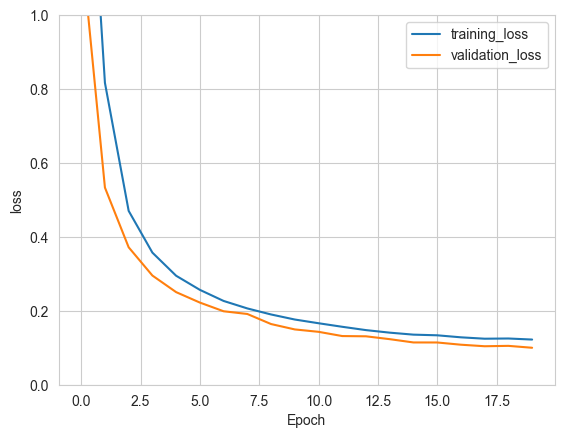

In [103]:

plot_learning_curve_loss(history_after_tuning.history, 0, 1)

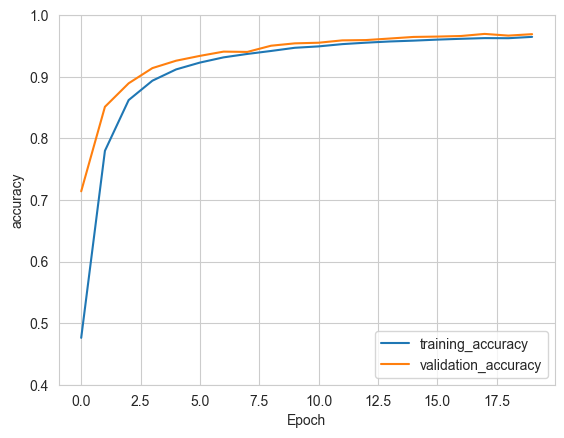

In [105]:

plot_learning_curve_metric(history_after_tuning.history, 0.4, 1)


## The following plots are to demonstrate what can go wrong during the tuning process.

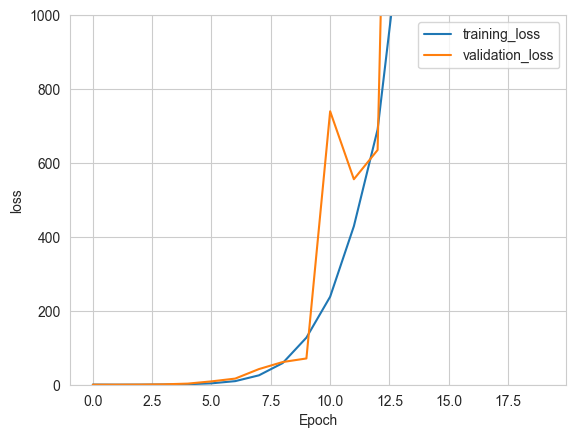

In [47]:
The upper limit was in a weird range that it was not possible to include the value 

plot_learning_curve_loss(history_after_tuning.history, 0, 1000)


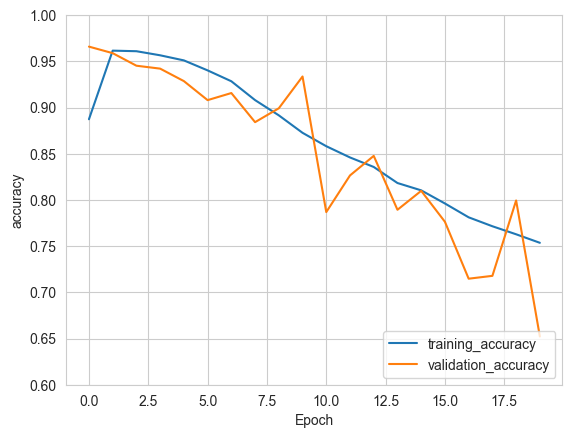

In [50]:
The accuracy is actually decreasing here - a sign that the process is directed in a wrong way

plot_learning_curve_metric(history_after_tuning.history, 0.6, 1)


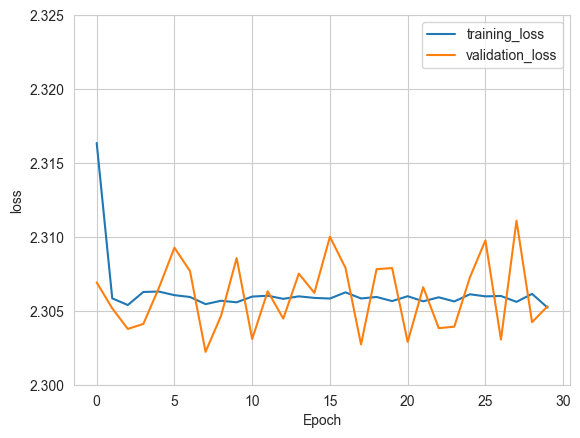

In [663]:
Unstable loss - not clear whether the model was learning at all. Definitely overfitting.

plot_learning_curve_loss(history_after_tuning.history, 2.3, 2.325)


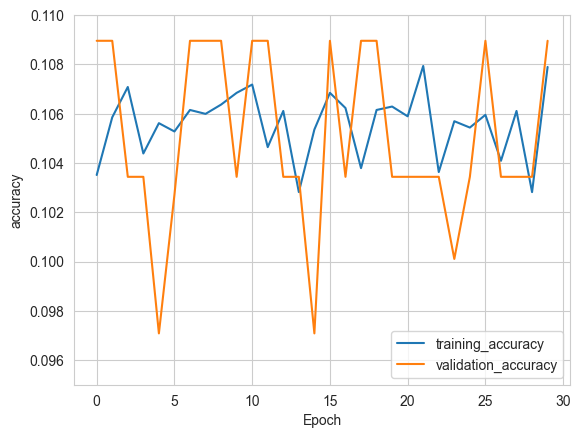

In [661]:
Unstable metric plot - the validation metric curve is very unstable and overfitting

plot_learning_curve_metric(history_after_tuning.history, 0.095, 0.11)



## When trained the model to find the optimum number of epochs to train the final model for. The below two plots demonstrate how the process went.



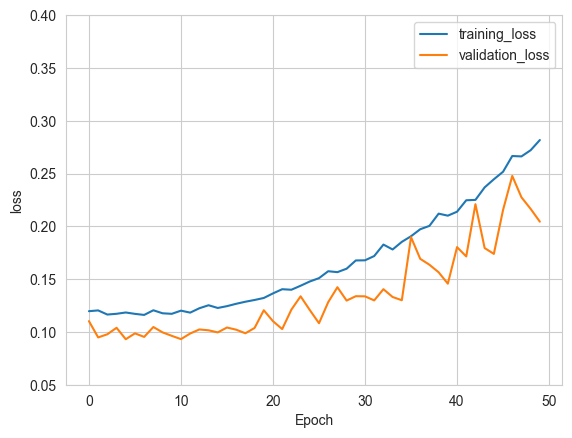

In [115]:

plot_learning_curve_loss(history_epochs.history, 0.05, 0.4)


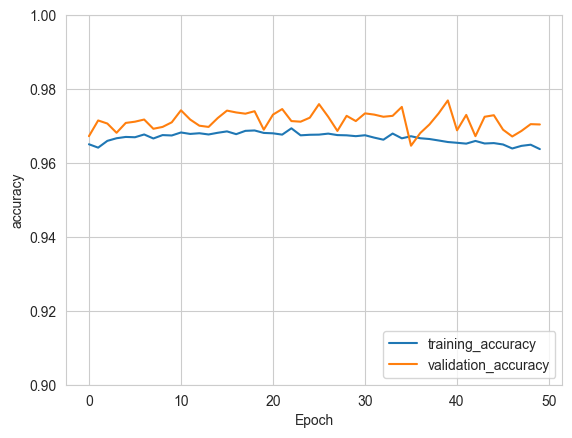

In [117]:

plot_learning_curve_metric(history_epochs.history, 0.9, 1)


In [109]:
Awesome test result!

eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)


313/313 [==============================] - 2s 5ms/step - loss: 0.0892 - accuracy: 0.9730
[test loss, test accuracy]: [0.0891772136092186, 0.9729999899864197]
